# Predict Fantasy Points per Position Using Random Forest Regression Model
Luke Brown | Dylan DiGoia | Shawn Killpack | Sean Olson

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# import supervised learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import RFE, RFECV
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# import regression libraries
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, classification_report, roc_auc_score, roc_curve

pd.set_option('display.max_rows', 200)

proFootballReferenceFiles = ['./data/ProFootballReference_Fantasy_Demographics.csv',
                            './data/ProFootballReference_Fantasy_Scoring.csv',
                            './data/ProFootballReference_Fantasy_Receiving.csv',
                            './data/ProFootballReference_Fantasy_Passing.csv',
                            './data/ProFootballReference_Fantasy_Rushing.csv',
                            './data/ProFootballReference_Fantasy_Receiving_Advanced.csv',
                            './data/ProFootballReference_Fantasy_Rushing_Advanced.csv',
                            './data/ProFootballReference_Fantasy_Approximate_Value.csv']
indexCols = ['player','year_id']
rawData = pd.read_csv('./data/ProFootballReference_Fantasy_Demographics.csv').drop(columns=['_type']).set_index(indexCols) 

for fileNm in proFootballReferenceFiles:
    if fileNm != './data/ProFootballReference_Fantasy_Demographics.csv':
        newDf = pd.read_csv(fileNm).drop(columns=['_type']).set_index(indexCols)
        cols_to_use = newDf.columns.difference(rawData.columns)
        rawData=pd.merge(rawData, newDf[cols_to_use], left_index=True, right_index=True, how='outer')
rawData.head(20)

age   bmi     g    gs height_in league_id  \
player      year_id                                               
A.J. Cann   2015     24.0  40.6  14.0  13.0       6-3       NFL   
            2016     25.0  40.6  16.0  16.0       6-3       NFL   
            2017     26.0  40.6  15.0  15.0       6-3       NFL   
            2018     27.0  40.6  15.0  15.0       6-3       NFL   
A.J. Derby  2016     25.0  28.5  10.0   3.0       6-5       NFL   
            2017     26.0  28.5  11.0   1.0       6-5       NFL   
            2018     27.0  28.5   4.0   0.0       6-5       NFL   
A.J. Feeley 2001     24.0  27.5   1.0   0.0       6-3       NFL   
            2002     25.0  27.5   6.0   5.0       6-3       NFL   
            2004     27.0  27.5  11.0   8.0       6-3       NFL   
            2006     29.0  27.5   2.0   0.0       6-3       NFL   
            2007     30.0  27.5   3.0   2.0       6-3       NFL   
            2011     34.0  27.5   5.0   3.0       6-3       NFL   
A.J. Green  2011     23.0  25.6  15.0  15.0       6-4       NFL   
            2012     24.0  25.6  16.0  16.0       6-4       NFL   
            2013     25.0  25.6  16.0  16.0       6-4       NFL   
            2014     26.0  25.6  13.0  13.0       6-4       NFL   
            2015     27.0  25.6  16.0  16.0       6-4       NFL   
            2016     28.0  25.6  10.0  10.0       6-4       NFL   
            2017     29.0  25.6  16.0  16.0       6-4       NFL   

                    psl_draft_info team  weight  all_td  ...  rec_yds_per_g  \
player      year_id                                      ...                  
A.J. Cann   2015              3-67  JAX   325.0     0.0  ...            0.0   
            2016              3-67  JAX   325.0     0.0  ...            0.0   
            2017              3-67  JAX   325.0     0.0  ...            0.0   
            2018              3-67  JAX   325.0     0.0  ...            0.0   
A.J. Derby  2016             6-202  2TM   240.0     0.0  ...           16.0   
            2017             6-202  2TM   240.0     2.0  ...           22.2   
            2018             6-202  MIA   240.0     1.0  ...           12.0   
A.J. Feeley 2001             5-155  PHI   220.0     0.0  ...            0.0   
            2002             5-155  PHI   220.0     0.0  ...            0.0   
            2004             5-155  MIA   220.0     1.0  ...            0.0   
            2006             5-155  PHI   220.0     0.0  ...            0.0   
            2007             5-155  PHI   220.0     0.0  ...            0.0   
            2011             5-155  STL   220.0     0.0  ...            0.0   
A.J. Green  2011               1-4  CIN   210.0     7.0  ...           70.5   
            2012               1-4  CIN   210.0    11.0  ...           84.4   
            2013               1-4  CIN   210.0    11.0  ...           89.1   
            2014               1-4  CIN   210.0     6.0  ...           80.1   
            2015               1-4  CIN   210.0    10.0  ...           81.1   
            2016               1-4  CIN   210.0     4.0  ...           96.4   
            2017               1-4  CIN   210.0     8.0  ...           67.4   

                     rec_yds_per_rec  rec_yds_per_tgt  targets  \
player      year_id                                              
A.J. Cann   2015                 NaN              NaN      0.0   
            2016                 NaN              NaN      0.0   
            2017                 NaN              NaN      0.0   
            2018                 NaN              NaN      0.0   
A.J. Derby  2016               10.00             8.00     20.0   
            2017               11.62             6.10     40.0   
            2018               16.00             9.60      5.0   
A.J. Feeley 2001                 NaN              NaN      0.0   
            2002                 NaN              NaN      0.0   
            2004                 NaN              NaN      0.0   
            2006

In [2]:
rawData.columns.tolist()

['age',
 'bmi',
 'g',
 'gs',
 'height_in',
 'league_id',
 'psl_draft_info',
 'team',
 'weight',
 'all_td',
 'fg_perc',
 'fga',
 'fgm',
 'safety_md',
 'scoring',
 'two_pt_md',
 'xp_perc',
 'xpa',
 'xpm',
 'draftkings_points',
 'fanduel_points',
 'fantasy_points',
 'fantasy_points_ppr',
 'fumbles',
 'losses',
 'pass_att',
 'pass_cmp',
 'pass_int',
 'pass_td',
 'pass_yds',
 'pos',
 'rec',
 'rec_td',
 'rec_yds',
 'rush_att',
 'rush_td',
 'rush_yds',
 'ties',
 'wins',
 'comebacks',
 'gwd',
 'pass_adj_net_yds_per_att',
 'pass_adj_yds_per_att',
 'pass_cmp_perc',
 'pass_int_perc',
 'pass_int_td',
 'pass_rating',
 'pass_sacked',
 'pass_sacked_yds',
 'pass_td_perc',
 'pass_yds_per_att',
 'pass_yds_per_g',
 'qb_l',
 'qb_t',
 'qb_w',
 'fantasy_points_per_game',
 'fantasy_points_ppr_per_game',
 'catch_pct',
 'rec_yds_per_g',
 'rec_yds_per_rec',
 'rec_yds_per_tgt',
 'targets',
 'rush_yds_per_att',
 'rush_yds_per_g',
 'all_pros_first_team',
 'av',
 'pro_bowls',
 'seasons']

In [3]:
cleanData = rawData.copy()

In [4]:
# There are a lot of players who never started, they aren't pertinant to us so remove them
cleanData=cleanData[cleanData['gs'].notna()]
cleanData=cleanData[cleanData['gs']!=0]
cleanData=cleanData[cleanData['g'].notna()]
cleanData=cleanData[cleanData['g']!=0]

cleanData.head(20)

age   bmi     g    gs height_in league_id  \
player       year_id                                               
A.J. Cann    2015     24.0  40.6  14.0  13.0       6-3       NFL   
             2016     25.0  40.6  16.0  16.0       6-3       NFL   
             2017     26.0  40.6  15.0  15.0       6-3       NFL   
             2018     27.0  40.6  15.0  15.0       6-3       NFL   
A.J. Derby   2016     25.0  28.5  10.0   3.0       6-5       NFL   
             2017     26.0  28.5  11.0   1.0       6-5       NFL   
A.J. Feeley  2002     25.0  27.5   6.0   5.0       6-3       NFL   
             2004     27.0  27.5  11.0   8.0       6-3       NFL   
             2007     30.0  27.5   3.0   2.0       6-3       NFL   
             2011     34.0  27.5   5.0   3.0       6-3       NFL   
A.J. Green   2011     23.0  25.6  15.0  15.0       6-4       NFL   
             2012     24.0  25.6  16.0  16.0       6-4       NFL   
             2013     25.0  25.6  16.0  16.0       6-4       NFL   
             2014     26.0  25.6  13.0  13.0       6-4       NFL   
             2015     27.0  25.6  16.0  16.0       6-4       NFL   
             2016     28.0  25.6  10.0  10.0       6-4       NFL   
             2017     29.0  25.6  16.0  16.0       6-4       NFL   
             2018     30.0  25.6   9.0   9.0       6-4       NFL   
A.J. Jenkins 2013     24.0  26.0  16.0   1.0       6-0       NFL   
             2014     25.0  26.0   9.0   2.0       6-0       NFL   

                     psl_draft_info team  weight  all_td  ...  rec_yds_per_g  \
player       year_id                                      ...                  
A.J. Cann    2015              3-67  JAX   325.0     0.0  ...            0.0   
             2016              3-67  JAX   325.0     0.0  ...            0.0   
             2017              3-67  JAX   325.0     0.0  ...            0.0   
             2018              3-67  JAX   325.0     0.0  ...            0.0   
A.J. Derby   2016             6-202  2TM   240.0     0.0  ...           16.0   
             2017             6-202  2TM   240.0     2.0  ...           22.2   
A.J. Feeley  2002             5-155  PHI   220.0     0.0  ...            0.0   
             2004             5-155  MIA   220.0     1.0  ...            0.0   
             2007             5-155  PHI   220.0     0.0  ...            0.0   
             2011             5-155  STL   220.0     0.0  ...            0.0   
A.J. Green   2011               1-4  CIN   210.0     7.0  ...           70.5   
             2012               1-4  CIN   210.0    11.0  ...           84.4   
             2013               1-4  CIN   210.0    11.0  ...           89.1   
             2014               1-4  CIN   210.0     6.0  ...           80.1   
             2015               1-4  CIN   210.0    10.0  ...           81.1   
             2016               1-4  CIN   210.0     4.0  ...           96.4   
             2017               1-4  CIN   210.0     8.0  ...           67.4   
             2018               1-4  CIN   210.0     6.0  ...           77.1   
A.J. Jenkins 2013              1-30  KAN   192.0     0.0  ...            8.1   
             2014              1-30  KAN   192.0     0.0  ...           10.3   

                      rec_yds_per_rec  rec_yds_per_tgt  targets  \
player       year_id                                              
A.J. Cann    2015                 NaN              NaN      0.0   
             2016                 NaN              NaN      0.0   
             2017                 NaN              NaN      0.0   
             2018                 NaN              NaN      0.0   
A.J. Derby   2016               10.00             8.00     20.0   
             2017               11.62             6.10     40.0   
A.J. Feeley  2002                 NaN              NaN      0.0   
             2004                 NaN              NaN      0.0   
             2007                 NaN              NaN      0.0   
             2011           

In [5]:
# There are also non-fantasy positions in here that we should get rid of.
fantasyPositions = ['QB',
                   'WR',
                   'RB',
                   'HB',
                   'FB',
                   'TE']
cleanData = cleanData[cleanData['pos'].isin(fantasyPositions)]

# Since we dropped kickers & defense (there wasn't signifigant data on them and they aren't particularly useful for our question)
# Drop the kicking and defense stats
unimportantStats = ['fg_perc',
                    'fga',
                    'fgm',
                    'safety_md',
                    'xp_perc',
                    'xpa',
                    'xpm']
cleanData=cleanData.drop(unimportantStats,axis=1)
cleanData.shape

(14734, 61)

In [6]:
# Got some duplicates. This could be problematic so we'll remove them
cleanData = cleanData.loc[~cleanData.index.duplicated(keep='first')]
cleanData.shape

(7287, 61)

In [7]:
# Assume any player with an NA for points got 0 points
pointCols = ['fantasy_points',
            'draftkings_points',
            'fanduel_points',
            'fantasy_points_ppr',
            'fantasy_points_per_game',
            'fantasy_points_ppr_per_game']

for pointCol in pointCols:
    cleanData[pointCol] = np.where(cleanData[pointCol].isna(),0,cleanData[pointCol])

In [8]:
# Some columns have no variance, lets remove those
cleanData = cleanData.loc[:,cleanData.apply(pd.Series.nunique) != 1]
display(cleanData.describe())

,age,bmi,g,gs,weight,all_td,scoring,two_pt_md,draftkings_points,fanduel_points,...,fantasy_points_ppr_per_game,rec_yds_per_g,rec_yds_per_rec,rec_yds_per_tgt,targets,rush_yds_per_att,rush_yds_per_g,all_pros_first_team,av,pro_bowls
count,7287.000000,7286.000000,7287.000000,7287.000000,7286.000000,7287.000000,7286.000000,530.000000,7287.000000,7287.000000,...,7287.000000,7287.000000,6205.000000,6316.000000,7267.000000,4136.000000,7286.00000,7287.000000,7287.000000,7287.000000
mean,26.827227,29.154900,12.863593,7.805681,224.986961,2.765884,16.763245,1.122642,104.958405,88.732249,...,7.562381,20.832469,10.508421,6.427587,40.337416,4.154877,10.35818,0.019212,4.355839,0.093866
std,3.476707,2.620789,4.009843,5.367203,25.640650,3.328823,20.098046,0.376604,92.645968,80.429884,...,5.675280,22.288423,4.350691,3.046842,40.961121,3.959871,21.20179,0.137280,4.234226,0.291662
min,21.000000,22.300000,1.000000,1.000000,160.000000,0.000000,0.000000,1.000000,-2.300000,-3.000000,...,-3.640000,-5.000000,-16.000000,-16.000000,0.000000,-18.000000,-16.00000,0.000000,-5.000000,0.000000
25%,24.000000,27.200000,11.000000,3.000000,205.000000,0.000000,0.000000,1.000000,27.900000,22.700000,...,2.620000,2.900000,7.680000,4.950000,7.000000,2.600000,0.00000,0.000000,1.000000,0.000000
50%,26.000000,29.000000,15.000000,7.000000,222.000000,2.000000,12.000000,1.000000,78.300000,65.500000,...,6.640000,13.200000,10.410000,6.460000,27.000000,3.900000,0.30000,0.000000,3.000000,0.000000
75%,29.000000,31.000000,16.000000,13.000000,247.000000,4.000000,24.000000,1.000000,161.100000,134.600000,...,11.495000,32.200000,13.070000,7.910000,63.000000,5.000000,7.80000,0.000000,6.500000,0.000000
max,44.000000,42.800000,16.000000,16.000000,370.000000,31.000000,186.000000,4.000000,512.100000,453.100000,...,32.850000,122.800000,46.000000,43.000000,205.000000,67.000000,131.10000,1.000000,26.000000,1.000000


In [9]:
# One row has a player with no demographic data. We'll throw this out as an outlier / data heigene error
cleanData = cleanData[cleanData['bmi'].notna()]

In [10]:
cleanData.columns[cleanData.isna().any()].tolist()
#The remaining NA rows makes sense due to different positions and players having different stats that matter. 
# Generally the software will handle this appropriately so there is no need to coalesce them

['psl_draft_info',
 'scoring',
 'two_pt_md',
 'fumbles',
 'pass_att',
 'pass_cmp',
 'pass_int',
 'pass_td',
 'pass_yds',
 'rec',
 'rec_td',
 'rec_yds',
 'rush_att',
 'rush_td',
 'rush_yds',
 'comebacks',
 'gwd',
 'pass_adj_net_yds_per_att',
 'pass_adj_yds_per_att',
 'pass_cmp_perc',
 'pass_int_perc',
 'pass_int_td',
 'pass_rating',
 'pass_sacked',
 'pass_sacked_yds',
 'pass_td_perc',
 'pass_yds_per_att',
 'pass_yds_per_g',
 'qb_l',
 'qb_t',
 'qb_w',
 'catch_pct',
 'rec_yds_per_rec',
 'rec_yds_per_tgt',
 'targets',
 'rush_yds_per_att',
 'rush_yds_per_g']

In [11]:
# Take a look at the correlation matrix to check for redundant data before moving forward
cleanData.corr().style.background_gradient(cmap='coolwarm')

In [12]:
# parse out positions
# QB
qbData = cleanData[cleanData['pos'] == 'QB']

# RB
rbData = cleanData[cleanData['pos'].isin(['RB', 'FB', 'HB'])]

# WR
wrData = cleanData[cleanData['pos'] == 'WR']

# TE
teData = cleanData[cleanData['pos'] == 'TE']

# confirm parsing
display(qbData['pos'].value_counts())
display(rbData['pos'].value_counts())
display(wrData['pos'].value_counts())
display(teData['pos'].value_counts())

QB    1042
Name: pos, dtype: int64

RB    1309
FB     614
HB      79
Name: pos, dtype: int64

WR    2545
Name: pos, dtype: int64

TE    1697
Name: pos, dtype: int64

In [13]:
# Keep relevant QB columns
qbcols = ['pass_yds', 'pass_td', 'rush_yds', 'rush_td', 'fumbles', 'pass_int', 'fantasy_points']
qbData = qbData[qbcols]

# Keep relevant RB columns
rbcols = ['rush_yds', 'rush_td', 'fumbles', 'rec_yds', 'rec_td', 'fantasy_points']
rbData = rbData[rbcols]

# Keep relevant WR columns
wrcols = ['rush_yds', 'rush_td', 'fumbles', 'rec_yds', 'rec_td', 'fantasy_points']
wrData = wrData[wrcols]

# Keep relevant TE columns
tecols = ['rush_yds', 'rush_td', 'fumbles', 'rec_yds', 'rec_td', 'fantasy_points']
teData = teData[tecols]

In [14]:
display(qbData.head(10))

pass_yds  pass_td  rush_yds  rush_td  fumbles  \
player        year_id                                                  
A.J. Feeley   2002       1011.0      6.0       6.0      0.0      0.0   
              2004       1893.0     11.0      13.0      1.0      0.0   
              2007        681.0      5.0      23.0      0.0      0.0   
              2011        548.0      1.0       4.0      0.0      3.0   
A.J. McCarron 2015        854.0      6.0      31.0      0.0      1.0   
Aaron Brooks  2000       1514.0      9.0     170.0      2.0      0.0   
              2001       3832.0     26.0     358.0      1.0      0.0   
              2002       3572.0     27.0     253.0      2.0      0.0   
              2003       3546.0     24.0     175.0      2.0      0.0   
              2004       3810.0     21.0     173.0      4.0      0.0   

                       pass_int  fantasy_points  
player        year_id                            
A.J. Feeley   2002          5.0           53.04  
              2004         15.0           91.02  
              2007          8.0           33.54  
              2011          2.0           20.32  
A.J. McCarron 2015          2.0           55.46  
Aaron Brooks  2000          6.0          111.96  
              2001         22.0          253.08  
              2002         15.0          252.18  
              2003          8.0          229.34  
              2004         16.0          243.80

In [15]:
## QB
# remove players with less than 1 year of data
yearsbyqb = qbData.groupby(['player']).count()
qbYears = yearsbyqb[yearsbyqb['fantasy_points'] > 1]
qbYears_idx = qbYears.index.get_level_values(0)

# index intersection
qb_idx = qbData.index.get_level_values(0).intersection(qbYears_idx)

# parse dataframe
qbData = qbData.loc[qb_idx]

## RB
# remove players with less than 1 year of data
yearsbyrb = rbData.groupby(['player']).count()
rbYears = yearsbyrb[yearsbyrb['fantasy_points'] > 1]
rbYears_idx = rbYears.index.get_level_values(0)

# index intersection
rb_idx = rbData.index.get_level_values(0).intersection(rbYears_idx)

# parse dataframe
rbData = rbData.loc[rb_idx]

## WR
# remove players with less than 1 year of data
yearsbywr = wrData.groupby(['player']).count()
wrYears = yearsbywr[yearsbywr['fantasy_points'] > 1]
wrYears_idx = wrYears.index.get_level_values(0)

# index intersection
wr_idx = wrData.index.get_level_values(0).intersection(wrYears_idx)

# parse dataframe
wrData = wrData.loc[wr_idx]

## TE
# remove players with less than 1 year of data
yearsbyte = teData.groupby(['player']).count()
teYears = yearsbyte[yearsbyte['fantasy_points'] > 1]
teYears_idx = teYears.index.get_level_values(0)

# index intersection
te_idx = teData.index.get_level_values(0).intersection(teYears_idx)

# parse dataframe
teData = teData.loc[te_idx]

In [16]:
display(qbData.head(30))

pass_yds  pass_td  rush_yds  rush_td  fumbles  \
player        year_id                                                  
A.J. Feeley   2002       1011.0      6.0       6.0      0.0      0.0   
              2004       1893.0     11.0      13.0      1.0      0.0   
              2007        681.0      5.0      23.0      0.0      0.0   
              2011        548.0      1.0       4.0      0.0      3.0   
Aaron Brooks  2000       1514.0      9.0     170.0      2.0      0.0   
              2001       3832.0     26.0     358.0      1.0      0.0   
              2002       3572.0     27.0     253.0      2.0      0.0   
              2003       3546.0     24.0     175.0      2.0      0.0   
              2004       3810.0     21.0     173.0      4.0      0.0   
              2005       2882.0     13.0     281.0      2.0      0.0   
              2006       1105.0      3.0     124.0      0.0      0.0   
Aaron Rodgers 2008       4038.0     28.0     207.0      4.0     10.0   
              2009       4434.0     30.0     316.0      5.0     10.0   
              2010       3922.0     28.0     356.0      4.0      4.0   
              2011       4643.0     45.0     257.0      3.0      4.0   
              2012       4295.0     39.0     259.0      2.0      5.0   
              2013       2536.0     17.0     120.0      0.0      4.0   
              2014       4381.0     38.0     269.0      2.0     10.0   
              2015       3821.0     31.0     344.0      1.0      8.0   
              2016       4428.0     40.0     369.0      4.0      8.0   
              2017       1675.0     16.0     126.0      0.0      1.0   
              2018       4442.0     25.0     269.0      2.0      6.0   
Akili Smith   2000       1253.0      3.0     232.0      0.0      0.0   
              2001         37.0      0.0      20.0      0.0      0.0   
              2002        117.0      0.0       5.0      0.0      0.0   
Alex Smith    2006       2890.0     16.0     147.0      2.0      0.0   
              2009       2350.0     18.0      51.0      0.0      3.0   
              2010       2370.0     14.0      60.0      0.0      4.0   
              2011       3144.0     17.0     179.0      2.0      7.0   
              2012       1737.0     13.0     132.0      0.0      3.0   

                       pass_int  fantasy_points  
player        year_id                            
A.J. Feeley   2002          5.0           53.04  
              2004         15.0           91.02  
              2007          8.0           33.54  
              2011          2.0           20.32  
Aaron Brooks  2000          6.0          111.96  
              2001         22.0          253.08  
              2002         15.0          252.18  
              2003          8.0          229.34  
              2004         16.0          243.80  
              2005         17.0          169.38  
              2006          8.0           50.60  
Aaron Rodgers 2008         13.0          290.22  
              2009          7.0          344.96  
              2010         11.0          304.48  
              2011          6.0          397.42  
              2012          8.0          343.60  
              2013          6.0          169.44  
              2014          5.0          354.14  
              2015          8.0          301.24  
              2016          7.0          380.02  
              2017          6.0          129.60  
              2018          2.0          312.58  
Akili Smith   2000          6.0           57.32  
              2001          0.0            3.48  
              2002          1.0            1.18  
Alex Smith    2006         16.0          164.30  
              2009         12.0          144.50  
              2010         10.0          136.80  
              2011          5.0          211.66  
              2012          5.0          122.68

In [17]:
## QB
# keep last index value as separate dataframe
qbData_last = qbData[~qbData.index.get_level_values(0).duplicated(keep='last')]
display(qbData_last.head())

# drop last value from other dataframe
qbData = qbData.drop(index = qbData_last.index)
display(qbData.head(20))

## RB
# keep last index value as separate dataframe
rbData_last = rbData[~rbData.index.get_level_values(0).duplicated(keep='last')]

# drop last value from other dataframe
rbData = rbData.drop(index = rbData_last.index)

## WR
# keep last index value as separate dataframe
wrData_last = wrData[~wrData.index.get_level_values(0).duplicated(keep='last')]

# drop last value from other dataframe
wrData = wrData.drop(index = wrData_last.index)

## TE
# keep last index value as separate dataframe
teData_last = teData[~teData.index.get_level_values(0).duplicated(keep='last')]

# drop last value from other dataframe
teData = teData.drop(index = teData_last.index)

,,pass_yds,pass_td,rush_yds,rush_td,fumbles,pass_int,fantasy_points
player,year_id,,,,,,,
A.J. Feeley,2011,548.0,1.0,4.0,0.0,3.0,2.0,20.32
Aaron Brooks,2006,1105.0,3.0,124.0,0.0,0.0,8.0,50.60
Aaron Rodgers,2018,4442.0,25.0,269.0,2.0,6.0,2.0,312.58
Akili Smith,2002,117.0,0.0,5.0,0.0,0.0,1.0,1.18
Alex Smith,2018,2180.0,10.0,168.0,1.0,6.0,5.0,138.00


pass_yds  pass_td  rush_yds  rush_td  fumbles  \
player        year_id                                                  
A.J. Feeley   2002       1011.0      6.0       6.0      0.0      0.0   
              2004       1893.0     11.0      13.0      1.0      0.0   
              2007        681.0      5.0      23.0      0.0      0.0   
Aaron Brooks  2000       1514.0      9.0     170.0      2.0      0.0   
              2001       3832.0     26.0     358.0      1.0      0.0   
              2002       3572.0     27.0     253.0      2.0      0.0   
              2003       3546.0     24.0     175.0      2.0      0.0   
              2004       3810.0     21.0     173.0      4.0      0.0   
              2005       2882.0     13.0     281.0      2.0      0.0   
Aaron Rodgers 2008       4038.0     28.0     207.0      4.0     10.0   
              2009       4434.0     30.0     316.0      5.0     10.0   
              2010       3922.0     28.0     356.0      4.0      4.0   
              2011       4643.0     45.0     257.0      3.0      4.0   
              2012       4295.0     39.0     259.0      2.0      5.0   
              2013       2536.0     17.0     120.0      0.0      4.0   
              2014       4381.0     38.0     269.0      2.0     10.0   
              2015       3821.0     31.0     344.0      1.0      8.0   
              2016       4428.0     40.0     369.0      4.0      8.0   
              2017       1675.0     16.0     126.0      0.0      1.0   
Akili Smith   2000       1253.0      3.0     232.0      0.0      0.0   

                       pass_int  fantasy_points  
player        year_id                            
A.J. Feeley   2002          5.0           53.04  
              2004         15.0           91.02  
              2007          8.0           33.54  
Aaron Brooks  2000          6.0          111.96  
              2001         22.0          253.08  
              2002         15.0          252.18  
              2003          8.0          229.34  
              2004         16.0          243.80  
              2005         17.0          169.38  
Aaron Rodgers 2008         13.0          290.22  
              2009          7.0          344.96  
              2010         11.0          304.48  
              2011          6.0          397.42  
              2012          8.0          343.60  
              2013          6.0          169.44  
              2014          5.0          354.14  
              2015          8.0          301.24  
              2016          7.0          380.02  
              2017          6.0          129.60  
Akili Smith   2000          6.0           57.32

## QB Analysis

In [18]:
### Random Forest Models for Regression to determine Fantasy Points based on relevant statistics
## QB
# setup random forest model dataframes
qbX_rf = qbData.drop('fantasy_points', axis = 1)
qbY_rf = qbData['fantasy_points']

# separate into testing (validation) and training datasets
qbXrf_train, qbXrf_test, qbYrf_train, qbYrf_test = train_test_split(qbX_rf, qbY_rf, test_size=0.30, random_state=0)

# create random forest model
qb_rfc = RandomForestRegressor()
qb_rfc.fit(qbXrf_train, qbYrf_train)

# predict using random forest model
qb_rfc_predict = qb_rfc.predict(qbXrf_test)

# Evaluate model performance
# calculate absolute errors
qb_errors = abs(qb_rfc_predict - qbYrf_test)

# Print out Mean Absolute Error
print('Mean Absolute Error: ', round(np.mean(qb_errors), 3), 'fantasy points per QB per Year')

# Determine Performance Metrics
# Calculate Mean Absolute Percentage Error
qb_mape = 100 * (qb_errors/qbYrf_test)

# Calculate and display accuracy
qb_accuracy = 100 - np.mean(qb_mape)
print('Accuracy: ', round(qb_accuracy, 3), '%')

Mean Absolute Error:  8.874 fantasy points per QB per Year
Accuracy:  94.709 %


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [19]:
# QB Decision Tree View
# Saving feature names for later use
qb_feature_list = list(qbX_rf.columns)

# Limit depth of tree to 3 levels
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Build tree view
qb_rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
qb_rf_small.fit(qbXrf_train, qbYrf_train)# Extract the small tree
qb_tree_small = qb_rf_small.estimators_[5]# Save the tree as a png image
export_graphviz(qb_tree_small, out_file = 'qb_small_tree.dot', feature_names = qb_feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('qb_small_tree.dot')
graph.write_png('qb_small_tree.png')

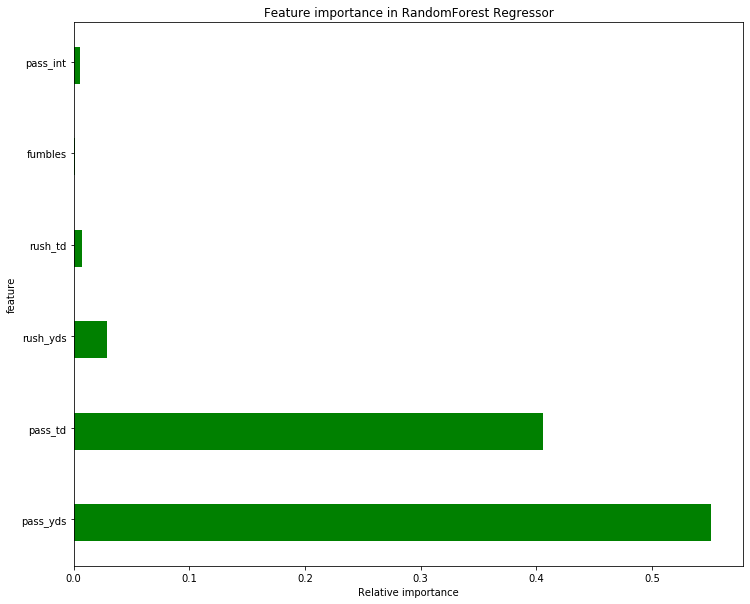

<Figure size 360x360 with 0 Axes>

In [20]:
# Plot Feature Importance
# modelname.feature_importance_
qb_y = qb_rfc.feature_importances_

# plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(qb_y)) # the x locations for the groups
ax.barh(ind, qb_y, width, color = 'green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(qb_feature_list, minor=False)
plt.title('Feature importance in RandomForest Regressor')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(5,5))
fig.set_size_inches(12, 10, forward=True)

In [21]:
# fit model to last year of data to test live error on qbData_last
# create dataframes
qblast_X_rf = qbData_last.drop('fantasy_points', axis = 1)
qblast_Y_rf = qbData_last['fantasy_points']

# predict using random forest model
qblast_rfc_predict = qb_rfc.predict(qblast_X_rf)

# Evaluate model performance
# calculate absolute errors
qblast_errors = abs(qblast_rfc_predict - qblast_Y_rf)

# Print out Mean Absolute Error
print('Mean Absolute Error: ', round(np.mean(qblast_errors), 3), 'fantasy points per QB for the most recent Year of data.')

# Determine Performance Metrics
# Calculate Mean Absolute Percentage Error
qblast_mape = 100 * (qblast_errors/qblast_Y_rf)

# Calculate and display accuracy
qblast_accuracy = 100 - np.mean(qblast_mape)
print('Accuracy: ', round(qblast_accuracy, 3), '%')

Mean Absolute Error:  7.078 fantasy points per QB for the most recent Year of data.
Accuracy:  64.225 %


## RB Analysis

In [22]:
### Random Forest Models for Regression to determine Fantasy Points based on relevant statistics
## RB
# setup random forest model dataframes
rbData = rbData.dropna()
rbX_rf = rbData.drop('fantasy_points', axis = 1)
rbY_rf = rbData['fantasy_points']

# separate into testing (validation) and training datasets
rbXrf_train, rbXrf_test, rbYrf_train, rbYrf_test = train_test_split(rbX_rf, rbY_rf, test_size=0.20, random_state=0)

# create random forest model
rb_rfc = RandomForestRegressor()
rb_rfc.fit(rbXrf_train, rbYrf_train)

# predict using random forest model
rb_rfc_predict = rb_rfc.predict(rbXrf_test)

# Evaluate model performance
# calculate absolute errors
rb_errors = abs(rb_rfc_predict - rbYrf_test)

# Print out Mean Absolute Error
print('Mean Absolute Error: ', round(np.mean(rb_errors), 3), 'fantasy points per RB per Year')

# Determine Performance Metrics
# Calculate Mean Absolute Percentage Error
rb_mape = 100 * (rb_errors/rbYrf_test)

# Calculate and display accuracy
rb_accuracy = 100 - np.mean(rb_mape)
print('Accuracy: ', round(rb_accuracy, 3), '%')

Mean Absolute Error:  5.484 fantasy points per RB per Year
Accuracy:  91.313 %


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [23]:
# rb Decision Tree View
# Saving feature names for later use
rb_feature_list = list(rbX_rf.columns)

# Limit depth of tree to 3 levels
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Build tree view
rb_rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rb_rf_small.fit(rbXrf_train, rbYrf_train)# Extract the small tree
rb_tree_small = rb_rf_small.estimators_[5]# Save the tree as a png image
export_graphviz(rb_tree_small, out_file = 'rb_small_tree.dot', feature_names = rb_feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('rb_small_tree.dot')
graph.write_png('rb_small_tree.png')

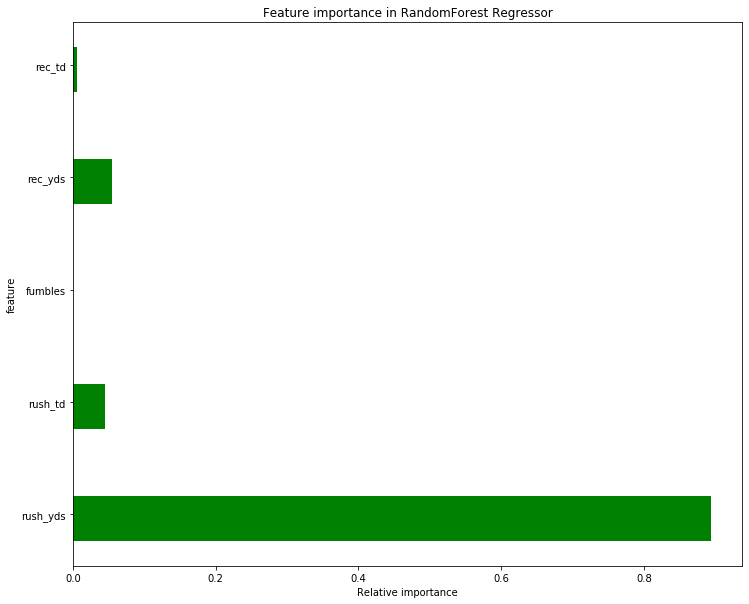

<Figure size 360x360 with 0 Axes>

In [24]:
# Plot Feature Importance
# modelname.feature_importance_
rb_y = rb_rfc.feature_importances_

# plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(rb_y)) # the x locations for the groups
ax.barh(ind, rb_y, width, color = 'green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(rb_feature_list, minor=False)
plt.title('Feature importance in RandomForest Regressor')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(5,5))
fig.set_size_inches(12, 10, forward=True)

In [25]:
# fit model to last year of data to test live error on rbData_last
# create dataframes
rbData_last = rbData_last.dropna()
rblast_X_rf = rbData_last.drop('fantasy_points', axis = 1)
rblast_Y_rf = rbData_last['fantasy_points']

# predict using random forest model
rblast_rfc_predict = rb_rfc.predict(rblast_X_rf)

# Evaluate model performance
# calculate absolute errors
rblast_errors = abs(rblast_rfc_predict - rblast_Y_rf)

# Print out Mean Absolute Error
print('Mean Absolute Error: ', round(np.mean(rblast_errors), 3), 'fantasy points per RB for the most recent Year of data.')

# Determine Performance Metrics
# Calculate Mean Absolute Percentage Error
rblast_mape = 100 * (rblast_errors/rblast_Y_rf)

# Calculate and display accuracy
rblast_accuracy = 100 - np.mean(rblast_mape)
print('Accuracy: ', round(rblast_accuracy, 3), '%')

Mean Absolute Error:  3.699 fantasy points per RB for the most recent Year of data.
Accuracy:  90.944 %


## WR Analysis

In [26]:
### Random Forest Models for Regression to determine Fantasy Points based on relevant statistics
## WR
# setup random forest model dataframes
wrData = wrData.dropna()
wrX_rf = wrData.drop('fantasy_points', axis = 1)
wrY_rf = wrData['fantasy_points']

# separate into testing (validation) and training datasets
wrXrf_train, wrXrf_test, wrYrf_train, wrYrf_test = train_test_split(wrX_rf, wrY_rf, test_size=0.20, random_state=0)

# create random forest model
wr_rfc = RandomForestRegressor()
wr_rfc.fit(wrXrf_train, wrYrf_train)

# predict using random forest model
wr_rfc_predict = wr_rfc.predict(wrXrf_test)

# Evaluate model performance
# calculate absolute errors
wr_errors = abs(wr_rfc_predict - wrYrf_test)

# Print out Mean Absolute Error
print('Mean Absolute Error: ', round(np.mean(wr_errors), 3), 'fantasy points per WR per Year')

# Determine Performance Metrics
# Calculate Mean Absolute Percentage Error
wr_mape = 100 * (wr_errors/wrYrf_test)

# Calculate and display accuracy
wr_accuracy = 100 - np.mean(wr_mape)
print('Accuracy: ', round(wr_accuracy, 3), '%')

Mean Absolute Error:  2.491 fantasy points per WR per Year
Accuracy:  96.29 %


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [27]:
# wr Decision Tree View
# Saving feature names for later use
wr_feature_list = list(wrX_rf.columns)

# Limit depth of tree to 3 levels
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Build tree view
wr_rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
wr_rf_small.fit(wrXrf_train, wrYrf_train)# Extract the small tree
wr_tree_small = wr_rf_small.estimators_[5]# Save the tree as a png image
export_graphviz(wr_tree_small, out_file = 'wr_small_tree.dot', feature_names = wr_feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('wr_small_tree.dot')
graph.write_png('wr_small_tree.png')

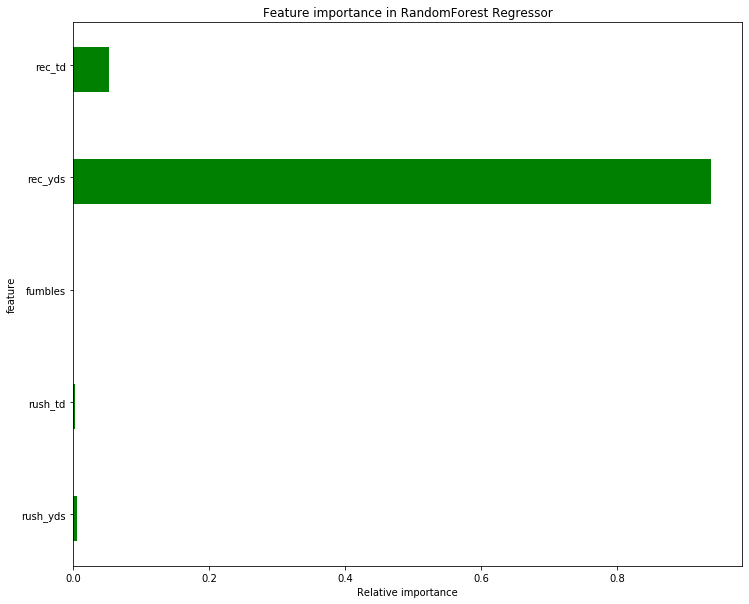

<Figure size 360x360 with 0 Axes>

In [28]:
# Plot Feature Importance
# modelname.feature_importance_
wr_y = wr_rfc.feature_importances_

# plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(wr_y)) # the x locations for the groups
ax.barh(ind, wr_y, width, color = 'green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(wr_feature_list, minor=False)
plt.title('Feature importance in RandomForest Regressor')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(5,5))
fig.set_size_inches(12, 10, forward=True)

In [29]:
# fit model to last year of data to test live error on wrData_last
# create dataframes
wrData_last = wrData_last.dropna()
wrlast_X_rf = wrData_last.drop('fantasy_points', axis = 1)
wrlast_Y_rf = wrData_last['fantasy_points']

# predict using random forest model
wrlast_rfc_predict = wr_rfc.predict(wrlast_X_rf)

# Evaluate model performance
# calculate absolute errors
wrlast_errors = abs(wrlast_rfc_predict - wrlast_Y_rf)

# Print out Mean Absolute Error
print('Mean Absolute Error: ', round(np.mean(wrlast_errors), 3), 'fantasy points per WR for the most recent Year of data.')

# Determine Performance Metrics
# Calculate Mean Absolute Percentage Error
wrlast_mape = 100 * (wrlast_errors/wrlast_Y_rf)

# Calculate and display accuracy
wrlast_accuracy = 100 - np.mean(wrlast_mape)
print('Accuracy: ', round(wrlast_accuracy, 3), '%')

Mean Absolute Error:  1.945 fantasy points per WR for the most recent Year of data.
Accuracy:  -inf %


## TE Analysis

In [30]:
### Random Forest Models for Regression to determine Fantasy Points based on relevant statistics
## TE
# setup random forest model dataframes
teData = teData.dropna()
teX_rf = teData.drop('fantasy_points', axis = 1)
teY_rf = teData['fantasy_points']

# separate into testing (validation) and training datasets
teXrf_train, teXrf_test, teYrf_train, teYrf_test = train_test_split(teX_rf, teY_rf, test_size=0.20, random_state=0)

# create random forest model
te_rfc = RandomForestRegressor()
te_rfc.fit(teXrf_train, teYrf_train)

# predict using random forest model
te_rfc_predict = te_rfc.predict(teXrf_test)

# Evaluate model performance
# calculate absolute errors
te_errors = abs(te_rfc_predict - teYrf_test)

# Print out Mean Absolute Error
print('Mean Absolute Error: ', round(np.mean(te_errors), 3), 'fantasy points per TE per Year')

# Determine Performance Metrics
# Calculate Mean Absolute Percentage Error
te_mape = 100 * (te_errors/teYrf_test)

# Calculate and display accuracy
te_accuracy = 100 - np.mean(te_mape)
print('Accuracy: ', round(te_accuracy, 3), '%')

Mean Absolute Error:  1.123 fantasy points per TE per Year
Accuracy:  96.863 %


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [31]:
# te Decision Tree View
# Saving feature names for later use
te_feature_list = list(teX_rf.columns)

# Limit depth of tree to 3 levels
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Build tree view
te_rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
te_rf_small.fit(teXrf_train, teYrf_train)# Extract the small tree
te_tree_small = te_rf_small.estimators_[5]# Save the tree as a png image
export_graphviz(te_tree_small, out_file = 'te_small_tree.dot', feature_names = te_feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('te_small_tree.dot')
graph.write_png('te_small_tree.png')

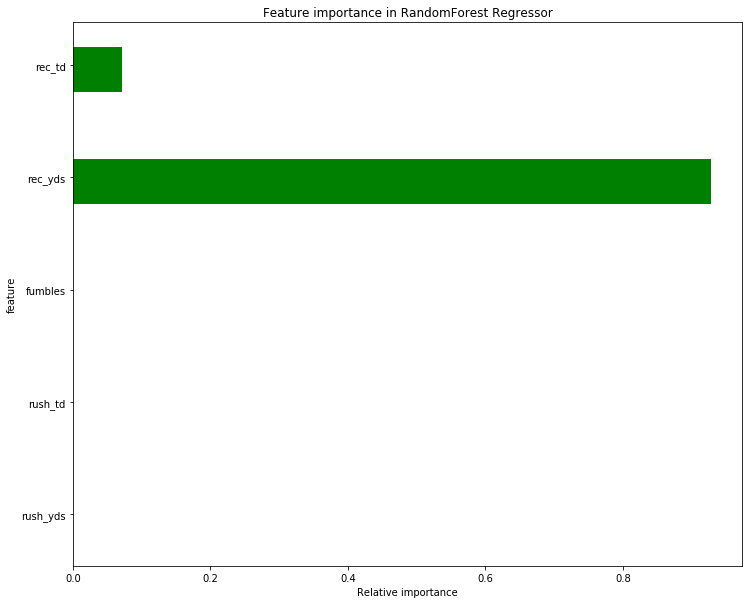

<Figure size 360x360 with 0 Axes>

In [32]:
# Plot Feature Importance
# modelname.feature_importance_
te_y = te_rfc.feature_importances_

# plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(te_y)) # the x locations for the groups
ax.barh(ind, te_y, width, color = 'green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(te_feature_list, minor=False)
plt.title('Feature importance in RandomForest Regressor')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(5,5))
fig.set_size_inches(12, 10, forward=True)

In [33]:
# fit model to last year of data to test live error on teData_last
# create dataframes
teData_last = teData_last.dropna()
telast_X_rf = teData_last.drop('fantasy_points', axis = 1)
telast_Y_rf = teData_last['fantasy_points']

# predict using random forest model
telast_rfc_predict = te_rfc.predict(telast_X_rf)

# Evaluate model performance
# calculate absolute errors
telast_errors = abs(telast_rfc_predict - telast_Y_rf)

# Print out Mean Absolute Error
print('Mean Absolute Error: ', round(np.mean(telast_errors), 3), 'fantasy points per te for the most recent Year of data.')

# Determine Performance Metrics
# Calculate Mean Absolute Percentage Error
telast_mape = 100 * (telast_errors/telast_Y_rf)

# Calculate and display accuracy
telast_accuracy = 100 - np.mean(telast_mape)
print('Accuracy: ', round(telast_accuracy, 3), '%')

Mean Absolute Error:  0.702 fantasy points per te for the most recent Year of data.
Accuracy:  94.144 %
